# Lockdown intensity through public bikes mobility data

With this analysis I would like to gain insights on the intensity of the lockdown in April at Oslo, through data on the use of public bikes. In general, the harder the lockdown, and the more it is respected by the public, the fewer the people travelling. Therefore we should be able to assess how strong the restrictions are, and how closely people are following them, by looking at mobility data.

In this analysis we are going to look at data about the use of the public shared bikes provided by the city of Oslo. We will compare the usage data from April 2020 with data from April 2019, which will be our baseline. As a first thought, we expect to see a decrease in the number of travels and in the total traveled time.

We start from a very simple analysis: by counting the number of rides and the total time traveled.

## Setup and total variation

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

df_19 = pd.read_csv('04-2019.csv',parse_dates=[0,1])
df_20 = pd.read_csv('04-2020.csv',parse_dates=[0,1])
df_19.head()

,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
0,2019-04-02 22:18:47.926,2019-04-02 22:24:25.427,337,401,Schous plass,nærmest Thorvald Meyers gate,"59,920259","10,760629",381,Grønlands torg,ved Tøyenbekken,"59,91252","10,76224"
1,2019-04-02 22:25:54.203,2019-04-02 22:27:36.114,101,556,Pilestredet,ved Sporveisgata,"59,9262242","10,7296246",556,Pilestredet,ved Sporveisgata,"59,9262242","10,7296246"
2,2019-04-02 22:26:39.308,2019-04-02 22:31:59.445,320,561,Kirkeveien,nord for Gørbitz' gate,"59,9335582","10,7264261",471,Marienlyst,i Suhms gate,"59,932454","10,721769"
3,2019-04-03 03:09:58.992,2019-04-03 03:12:00.589,121,393,Hans Nielsen Hauges plass,Mellom Åsengata og Nordkappgata,"59,939244","10,774319",393,Hans Nielsen Hauges plass,Mellom Åsengata og Nordkappgata,"59,939244","10,774319"
4,2019-04-03 03:10:02.415,2019-04-03 03:14:44.537,282,597,Fredensborg,ved rundkjøringen,"59,920995","10,750358",557,Akersgata,ved Grensen,"59,9141971","10,7428828"


In [79]:
df_19.dtypes

started_at                   datetime64[ns]
ended_at                     datetime64[ns]
duration                              int64
start_station_id                      int64
start_station_name                   object
start_station_description            object
start_station_latitude               object
start_station_longitude              object
end_station_id                        int64
end_station_name                     object
end_station_description              object
end_station_latitude                 object
end_station_longitude                object
dtype: object

In [80]:
df_19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235713 entries, 0 to 235712
Data columns (total 13 columns):
started_at                   235713 non-null datetime64[ns]
ended_at                     235713 non-null datetime64[ns]
duration                     235713 non-null int64
start_station_id             235713 non-null int64
start_station_name           235713 non-null object
start_station_description    235713 non-null object
start_station_latitude       235713 non-null object
start_station_longitude      235713 non-null object
end_station_id               235713 non-null int64
end_station_name             235713 non-null object
end_station_description      235713 non-null object
end_station_latitude         235713 non-null object
end_station_longitude        235713 non-null object
dtypes: datetime64[ns](2), int64(3), object(8)
memory usage: 23.4+ MB


The dataset has no missing values, and the data types correctly represent the data.

In [81]:
total_rides_variation = (len(df_20.index) / len(df_19.index)) - 1
total_rides_variation

-0.5019154649934454

Compared to 2019, there have been 50.19% fewer rides in 2020. There is no doubt that the main cause of this stark decrease was the lockdown caused by the Covid-19 pandemic.

## Analysis of the rides duration

### Detection and removal of outliers

In [82]:
#Durations are in seconds
df_19['duration'].head()

0    337
1    101
2    320
3    121
4    282
Name: duration, dtype: int64

In [83]:
total_duration_2019 = df_19['duration'].sum()
total_duration_2020 = df_20['duration'].sum()
total_duration_variation = (total_duration_2020 / total_duration_2019) -1
total_duration_variation

-0.4597291706479003

Compared to 2019, the total time traveled has shrinked by 45.97%. Again, this stark decrease is mainly caused mainly in the lockdown. We can also notice that the total time traveled has decreased less than the total number of rides. Therefore the average duration of a ride has actually increased. Let's then investigate the distribution of the rides durations in the two years.

In [84]:
df_19['duration'].describe()

count    2.357130e+05
mean     8.875432e+02
std      6.237237e+03
min      6.100000e+01
25%      3.300000e+02
50%      5.310000e+02
75%      8.890000e+02
max      1.135407e+06
Name: duration, dtype: float64

We can see that the maximum duration is way larger than the 75-th percentile, it is greater by a 10³ factor. This suggests that there are some outliers. Notice that there is no such problem on the lower tail of the duration series, as the minimum is reasonably lower than the 25-th percentile. We try to investigate this deeper.

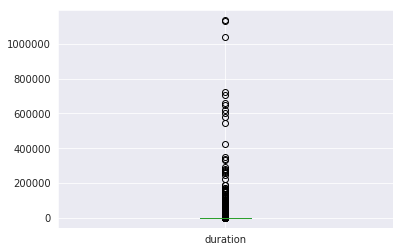

In [85]:
df_19['duration'].plot(kind='box');

The box plot appears completely flat, and there are few points way off.

In [86]:
outliers_19 = df_19[df_19['duration'] > 1000000]
outliers_19

,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
10673,2019-04-04 15:55:17.918,2019-04-16 17:10:45.381,1041327,574,Annette Thommessens Plass,langs Schweigaards gate,"59,9107393","10,7609998",588,Meltzers gate,ved Skovveien,"59,9180141","10,7184345"
22812,2019-04-06 12:12:32.245,2019-04-19 15:35:59.607,1135407,613,Schives gate,ved Arno Bergs plass,"59,9208044","10,7140544",532,Bryn T-Bane,Ved Østensjøveien,"59,909238","10,814199"
82710,2019-04-13 18:31:33.384,2019-04-26 21:09:08.363,1132654,437,Sentrum Scene,ved Arbeidersamfunnets plass,"59,915484","10,7510765",436,Vestkanttorvet,langs Tidemands gate,"59,9244031","10,7130691"


These three rides have a duration of 12-13 days. This is unusual at best, and likely an indication of some error in the measurement or of some misuse. As these rides are not representative of the standard usage, we drop them.

In [87]:
df_19 = df_19.drop(outliers_19.index)
len(df_19.index)

235710

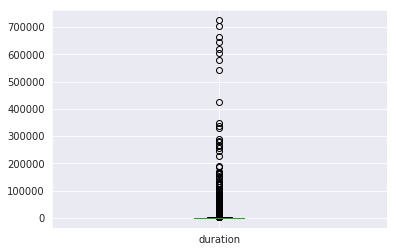

In [88]:
df_19['duration'].plot(kind='box');

As the box plot is still flat, it is clear that we have to remove further outliers. We will find outliers using the Z-score, which is the number of standard deviations that a datum is above or below the median. Generally, data with Z-score larger than 3 are considered outliers. 

In [89]:
from scipy.stats import zscore

In [90]:
z = np.abs(zscore(df_19['duration']))
outliers_19 = df_19[z>3]
outliers_19.head()

,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
677,2019-04-03 06:16:29.176,2019-04-03 11:22:09.290,18340,491,Vaterlandsparken II,ved Brugata,"59,9136458","10,7573198",399,Uelands gate,Ved Ulvetrappen (Ilatrappen),"59,929545","10,7489862"
2250,2019-04-03 13:30:25.922,2019-04-03 22:01:01.490,30635,436,Vestkanttorvet,langs Tidemands gate,"59,9244031","10,7130691",500,Anker Hostel,ved Storgata,"59,9172794","10,7581553"
3247,2019-04-03 15:37:38.554,2019-04-03 20:04:06.000,15987,443,Sjøsiden øst,nærmest trappen,"59,910178","10,751824",563,Huitfeldts gate,mellom Cort Adelers gate og Observatoriegata,"59,9126844","10,7229003"
3477,2019-04-03 16:09:15.307,2019-04-05 13:25:18.573,162963,625,Spikersuppa Øst,mot Stortingsgata,"59,91336","10,737663",445,Sjølyst,langs Drammensveien,"59,921673","10,67666"
4471,2019-04-03 19:03:19.791,2019-04-04 06:47:56.976,42277,398,Ringnes Park,ved Sannergata,"59,92852","10,76047",378,Colosseum Kino,langs Fridtjof Nansens vei,"59,929853","10,711515"


In [91]:
#Percentage of outliers
100*len(outliers_19.index) / len(df_19.index)

0.14254804632811505

The rows with Z-score strictly greater than 3 account for only 0.14% of the total data. We can safely drop these values, at least for studying the rides duration.

In [92]:
df_19 = df_19.drop(outliers_19.index)
df_19['duration'].describe()

count    235374.000000
mean        775.167644
std         823.462370
min          61.000000
25%         330.000000
50%         531.000000
75%         886.000000
max       15360.000000
Name: duration, dtype: float64

The description of the dataframe looks better now. Let's see how the box plot turns out.

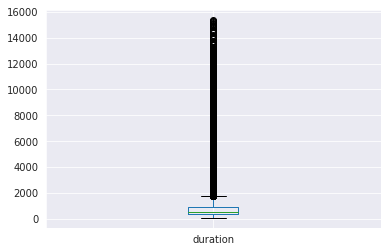

In [93]:
df_19['duration'].plot(kind='box');

This also looks better. We can now say that we have removed all data from the 2019 dataframes that were outliers in terms of the rides duration. This is the only sensible feature to evaluate outliers on, as the other numerical data are station IDs, or geographical coordinates.

We repeat the same study for the 2020 dataframe.

In [94]:
df_20['duration'].describe()

count    117405.000000
mean        962.715464
std        1283.649437
min          61.000000
25%         384.000000
50%         637.000000
75%        1107.000000
max      183081.000000
Name: duration, dtype: float64

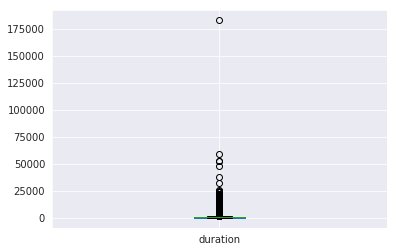

In [95]:
df_20['duration'].plot(kind='box');

In [96]:
z = np.abs(zscore(df_20['duration']))
outliers_20 = df_20[z>3]
outliers_20.head()

,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
450,2020-04-01 07:33:33.069,2020-04-01 09:27:38.603,6845,551,Olaf Ryes plass,langs Sofienberggata,59.922425,10.758182,551,Olaf Ryes plass,langs Sofienberggata,59.922425,10.758182
459,2020-04-01 07:39:15.461,2020-04-01 11:09:06.752,12591,458,Jenny Braatens Plass,langs Rosenhoffgata,59.928349,10.778370,737,Munkegata trikkestopp,langs Oslo gate,59.908255,10.767800
546,2020-04-01 08:38:09.301,2020-04-01 10:50:11.024,7921,468,Skillebekk,langs Drammensveien,59.912793,10.710103,468,Skillebekk,langs Drammensveien,59.912793,10.710103
857,2020-04-01 11:28:23.536,2020-04-01 14:13:45.385,9921,623,7 Juni Plassen,langs Henrik Ibsens gate,59.915060,10.731272,464,Sukkerbiten,ved gangbroen,59.905807,10.753657
884,2020-04-01 11:38:38.222,2020-04-01 13:07:50.894,5352,388,Skovveien,langs Frognerveien,59.916331,10.716349,418,Norsk Folkemuseum,utenfor inngangen,59.907674,10.686843


In [97]:
100*len(outliers_20.index) / len(df_20.index)

0.9897363826072143

In [98]:
df_20 = df_20.drop(outliers_20.index)
df_20['duration'].describe()

count    116243.000000
mean        886.546519
std         772.094440
min          61.000000
25%         382.000000
50%         631.000000
75%        1085.000000
max        4813.000000
Name: duration, dtype: float64

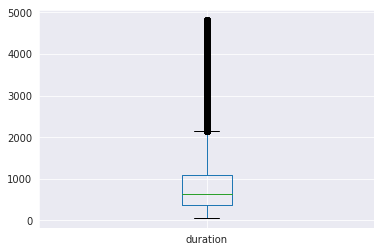

In [99]:
df_20['duration'].plot(kind='box');

### Study of the rides duration

Now that we have cleaned our dataframes, we can proceed with a more meaningful study. To start with, let's compare again average duration and total traveled time in the two years.

In [100]:
print(f"Total traveled time in 2019: {df_19['duration'].sum()} seconds. Average traveled time: {df_19['duration'].mean()} seconds.")
print(f"Total traveled time in 2020: {df_20['duration'].sum()} seconds. Average traveled time: {df_20['duration'].mean()} seconds.")

Total traveled time in 2019: 182454309 seconds. Average traveled time: 775.1676438349181 seconds.
Total traveled time in 2020: 103054827 seconds. Average traveled time: 886.5465189301722 seconds.


We confirm that the average time traveled has increased in 2020. Therefore the decrease in total time travelled is caused exclusively by the fewer total rides. Let's compare the distributions.

/usr/lib/python3/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


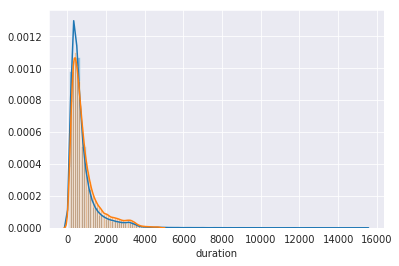

In [101]:
sns.distplot(df_19['duration']);
sns.distplot(df_20['duration']);

The chart is not very readable, due to the presence of rides with large duration. Let's then focus on the bulk of it:

/usr/lib/python3/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


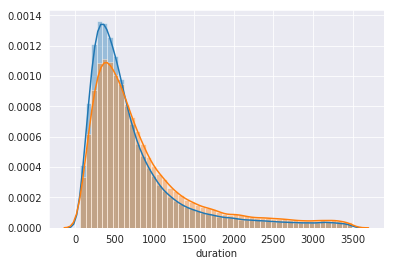

In [102]:
rides_filter19 = np.where(df_19['duration']<3500,True,False)
rides_filter20 = np.where(df_20['duration']<3500,True,False)
sns.distplot(df_19[rides_filter19]['duration']);
sns.distplot(df_20[rides_filter20]['duration']);

What we get from this distribution plot is that in 2020 we had fewer rides that lasted between 0 and about 800 seconds, but more rides lasting more than 800 seconds.

## Time series analysis

### Variation during the month

We now study how the number and duration of rides changed during the month in the two considered years. As a first approximation, we are going to ignore the distinction between weekdays and weekends.

In [195]:
groups = df_19.groupby(df_19['started_at'].dt.date)


days_19 = groups['duration'].aggregate([np.size,np.sum])
days_19.columns = ['Total rides','Total duration']
days_19.index = days_19.index.astype('datetime64[ns]').day
days_19.index.name = 'Day'
days_19['Year'] = 2019
days_19

,Total rides,Total duration,Year
Day,,,
2,3,758,2019
3,5017,3067059,2019
4,8014,5640040,2019
5,7619,5075983,2019
6,6869,5601060,2019
7,4999,4499821,2019
8,7571,4817534,2019
9,8776,5350613,2019
10,9349,5646287,2019


In [196]:
groups = df_20.groupby(df_20['started_at'].dt.date)


days_20 = groups['duration'].aggregate([np.size,np.sum])
days_20.columns = ['Total rides','Total duration']
days_20.index = days_20.index.astype('datetime64[ns]').day
days_20.index.name = 'Day'
days_20['Year'] = 2020
days_20

,Total rides,Total duration,Year
Day,,,
1,2825,2335024,2020
2,2141,1546751,2020
3,2926,2254184,2020
4,2944,2974345,2020
5,1827,1779061,2020
6,3816,3543888,2020
7,4241,3930040,2020
8,3453,2746289,2020
9,3545,3956230,2020


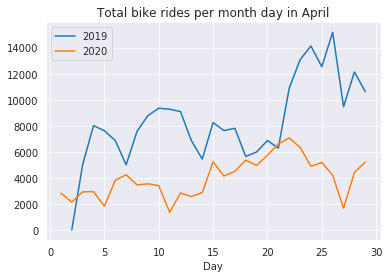

In [209]:
days_19['Total rides'].plot()
days_20['Total rides'].plot()
plt.legend(['2019','2020'])
plt.title('Total bike rides per month day in April');

If we plot alongside the 2019 and 2020 data, we can see that almost every day of the month there have been fewer rides in 2020. In particular, the gap narrows towards the 20th of April, and then widens again. This may be due to the fact that week 12-19 was Easter week in 2020, which is unrelated with the lockdown. However, before drawing conclusions we should also account for the weather and for the day of the week.

Let's visualize the relative variation.

In [213]:
df_variations = (days_20['Total rides'] / days_19['Total rides']) -1
df_variations.head()

Day
1           NaN
2    712.666667
3     -0.416783
4     -0.632643
5     -0.760205
Name: Total rides, dtype: float64

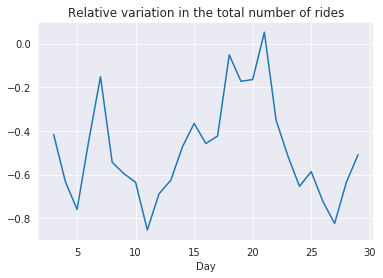

In [219]:
df_variations.loc[3:].plot(kind='line')
plt.title('Relative variation in the total number of rides');

As we saw in the previous chart, the relative variation compared to 2019 has been close to zero around the 20th of April, and near the end of the month it went back to levels similar to the week 5-12.

Let's make the same study for the duration of the rides.

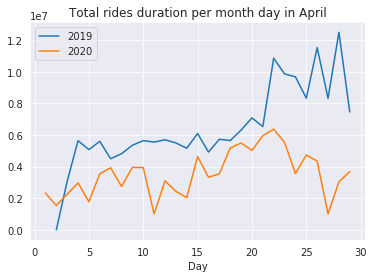

In [220]:
days_19['Total duration'].plot()
days_20['Total duration'].plot()
plt.legend(['2019','2020'])
plt.title('Total rides duration per month day in April');

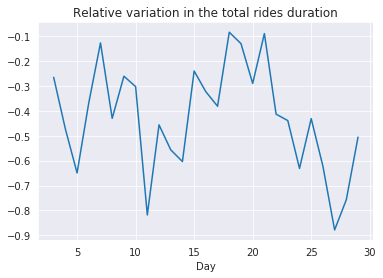

In [225]:
df_variations = (days_20['Total duration'] / days_19['Total duration']) -1
df_variations.loc[3:].plot(kind='line');
plt.title('Relative variation in the total rides duration');

The relative variation in total rides duration shows the same behaviour as the relative variation in the total number of rides, albeit less smooth.

This brief study is able to detect a spike in mobility in the period 12th-19th of April, which was Easter week in 2020. This surely denotes the fact that in those days the situation was similar to 2019, so it may hint at an ease of the lockdown, or at a less strict following of the lockdown rules by the population. Even with simple mobility data, we can see a clear increase in mobility to levels similar to 2019.

This first study is not conclusive on the _reasons_ though. We would be able to say more about this by plugging in weather data, the day of the week and the days when restrictions were lifted.

## Variation by day of the week

We now separate the days in weekdays and weekend, to investigate whether there is any difference in the mobility.

In [12]:
df = pd.concat([df_19,df_20])
mask_weekday = np.where(df.index.weekday < 5,"Weekday","Weekend")
df_year_weekday = df.groupby([df.index.year,mask_weekday])
df_year_weekday.count()

ended_at  duration  start_station_id  start_station_name  \
started_at                                                                     
2019       Weekday    176680    176680            176680              176680   
           Weekend     59033     59033             59033               59033   
2020       Weekday     88302     88302             88302               88302   
           Weekend     29103     29103             29103               29103   

                    start_station_description  start_station_latitude  \
started_at                                                              
2019       Weekday                     176680                  176680   
           Weekend                      59033                   59033   
2020       Weekday                      88302                   88302   
           Weekend                      29103                   29103   

                    start_station_longitude  end_station_id  end_station_name  \
started_at                                                                      
2019       Weekday                   176680          176680            176680   
           Weekend                    59033           59033             59033   
2020       Weekday                    88302           88302             88302   
           Weekend                    29103           29103             29103   

                    end_station_description  end_station_latitude  \
started_at                                                          
2019       Weekday                   176680                176680   
           Weekend                    59033                 59033   
2020       Weekday                    88302                 88302   
           Weekend                    29103                 29103   

                    end_station_longitude  
started_at                                 
2019       Weekday                 176680  
           Weekend                  59033  
2020       Weekday                  88302  
           Weekend                  29103

Text(0.5, 1.0, 'Average duration of a ride variation')

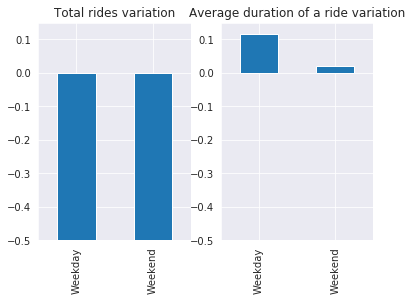

In [13]:
variarion_by_weekday = (df_year_weekday.count().loc[2020,'ended_at'] / df_year_weekday.count().loc[2019,'ended_at']) - 1
variarion_by_weekday2 = (df_year_weekday.mean().loc[2020,'duration'] / df_year_weekday.mean().loc[2019,'duration']) - 1
plt.subplot(121)
variarion_by_weekday.plot(kind='bar')
plt.ylim(-0.5,0.15)
plt.title('Total rides variation')
plt.subplot(122)
variarion_by_weekday2.plot(kind='bar')
plt.ylim(-0.5,0.15)
plt.title('Average duration of a ride variation')

The variation in the number rides is the same regardless of whether the considered day is a weekday or a weekend. As we saw, the average variation of a ride has increased, and it increased more in the weekdays.

## Variation by week

We now try to answer the following question: as the weeks passed by, did the people traveled more using the public bikes?

As said at the beginning, if we consider the bike usage a good sample of the overall mobility, by answering this question we can understand whether the Oslo residents traveled more in general, as the weeks passed by. Therefore, we can try to understand whether the lockdown was progressively eased (or ignored) or not.

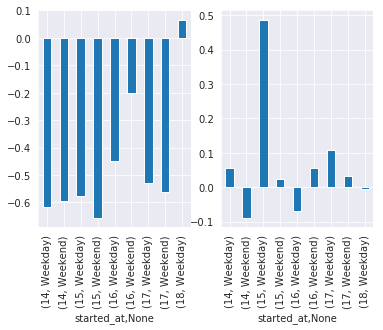

In [14]:
df_by_week = df.groupby([df.index.year,df.index.week,mask_weekday])
variarion_by_week = (df_by_week.count().loc[2020,'ended_at'] / df_by_week.count().loc[2019,'ended_at']) -1
variarion_by_week2 = (df_by_week.mean().loc[2020,'duration'] / df_by_week.mean().loc[2019,'duration']) - 1
plt.subplot(121)
variarion_by_week.plot(kind='bar')
plt.subplot(122)
variarion_by_week2.plot(kind='bar')

The decrease in the number of rides per week is almost constant except for two weeks. In particular, in the weekend of the 16th week people in Oslo seem to have picked up the public bikes again. As for the ride duration, in the 15th week there is a great spike in the variation! These two things are worth investigating. The standard suspects are public holidays and weather.

In [15]:
df[df.index.week==15]

,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
started_at,,,,,,,,,,,,
2019-04-08 03:00:04.569000+00:00,2019-04-08 03:07:08.793000+00:00,424,473,Majorstuveien,i Maries gate,"59,926697","10,716195",572,Skøyen,under broen,"59,922247","10,679738"
2019-04-08 03:00:56.178000+00:00,2019-04-08 03:11:29.629000+00:00,633,526,Lille Grensen,Ved Akersgata,"59,9138973","10,7423101",446,Bislett Stadion,ved rundkjøringen,"59,92549","10,731288"
2019-04-08 03:08:57.599000+00:00,2019-04-08 03:14:07.906000+00:00,310,464,Sukkerbiten,ved gangbroen til Sørenga,"59,905037","10,753698",574,Annette Thommessens Plass,langs Schweigaards gate,"59,9107393","10,7609998"
2019-04-08 03:11:04.306000+00:00,2019-04-08 03:15:33.005000+00:00,268,734,Nylandsveien,mellom Norbygata og Urtegata,"59,9156603","10,7622812",478,Jernbanetorget,på Europarådets plass,"59,911901","10,749929"
2019-04-08 03:18:54.700000+00:00,2019-04-08 03:21:02.409000+00:00,127,446,Bislett Stadion,ved rundkjøringen,"59,92549","10,731288",403,Parkveien,utenfor Katedralen pub,"59,921768","10,730476"
2019-04-08 03:27:18.956000+00:00,2019-04-08 03:34:25.880000+00:00,426,499,Bjerregaards gate,ovenfor Fredrikke Qvams gate,"59,925488","10,746058",557,Akersgata,ved Grensen,"59,9141971","10,7428828"
2019-04-08 03:28:30.265000+00:00,2019-04-08 03:32:54.406000+00:00,264,444,AHO,langs Maridalsveien,"59,925265","10,750462",384,Vår Frelsers gravlund sør,langs Ullevålsveien,"59,919463","10,743829"
2019-04-08 03:29:24.311000+00:00,2019-04-08 03:38:05.577000+00:00,521,593,Bjølsen mølle,i Sandakerveien,"59,9392","10,768774",478,Jernbanetorget,på Europarådets plass,"59,911901","10,749929"
2019-04-08 03:31:38.054000+00:00,2019-04-08 03:44:21.243000+00:00,763,525,Myraløkka Øst,langs Bentsenbrugata,"59,937205","10,7605813",558,Dokkveien,ved Støperigata,"59,910974","10,7277001"


The week ending in the 12th of April 2020 was indeed the week leading up to Easter. This was not the case in 2019, where Easter was the 21st of April. This explains the smaller decrease in the rides taken in that weekend---it was Easter weekend in 2020.

Except for this case, there is no sensible variation in the mobility decrease along the month. Of course there are other factors to be taken into account, but the from the data exploration done so far we draw the following hypothesis: the decrease in the mobility, particularly in bike mobility, has not varied sensibly during April 2020 (compared to April 2019).

This suggets that the lockdown has _not_ been ignored as weeks passed by, contrarily to what the eye test suggested. Beware again that this is not definitive: the residents could have in fact going outside more, just not using the public bikes. However, it surely tells us something about the usage of bikes to travel.

## Variation in the hourly trend during the day

We now further separate the different hours inside the day. This is useful because it helps us separate commute travel from leisure travel. Indeed, during weekdays the commute travel spikes around the start and end of the business day (and is generally the main contribution), while in the weekend it is absent.

In general, we do not formulate any prediction on whether the commute travel has decreased more, less or in the same measure as the leisure travel.

In [16]:
df_by_hour = df.groupby([df.index.year,mask_weekday,df.index.hour]).count()
df_by_hour

ended_at  duration  start_station_id  \
started_at         started_at                                         
2019       Weekday 0                  1         1                 1   
                   3                623       623               623   
                   4               3843      3843              3843   
                   5              11117     11117             11117   
                   6              13388     13388             13388   
                   7               6623      6623              6623   
                   8               4878      4878              4878   
                   9               5994      5994              5994   
                   10              7047      7047              7047   
                   11              8366      8366              8366   
                   12             10608     10608             10608   
                   13             13994     13994             13994   
                   14             19011     19011             19011   
                   15             17147     17147             17147   
                   16             14338     14338             14338   
                   17             11821     11821             11821   
                   18              9910      9910              9910   
                   19              7058      7058              7058   
                   20              5572      5572              5572   
                   21              3987      3987              3987   
                   22              1347      1347              1347   
                   23                 7         7                 7   
           Weekend 0                  8         8                 8   
                   1                  4         4                 4   
                   3                142       142               142   
                   4                286       286               286   
                   5                561       561               561   
                   6                844       844               844   
                   7               1596      1596              1596   
                   8               2152      2152              2152   
...                                 ...       ...               ...   
2020       Weekday 15              9220      9220              9220   
                   16              7444      7444              7444   
                   17              5849      5849              5849   
                   18              4322      4322              4322   
                   19              3154      3154              3154   
                   20              2313      2313              2313   
                   21              1307      1307              1307   
                   22               666       666               666   
                   23                 3         3                 3   
           Weekend 3                 36        36                36   
                   4                121       121               121   
                   5                333       333               333   
                   6                334       334               334   
                   7                592       592               592   
                   8               1023      1023              1023   
                   9               1735      1735              1735   
                   10              2376      2376              2376   
                   11              2747      2747              2747   
                   12              3262      3262              3262   
                   13              3319      3319              3319   
                   14              2952      2952              2952   
                   15              2589      2589              2589   
                   16              2209      2209              2209   
                   17              1731      1731      

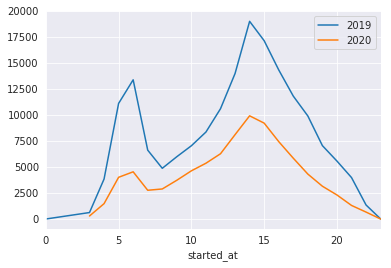

In [17]:
df_by_hour.loc[(2019,'Weekday'),'ended_at'].plot()
df_by_hour.loc[(2020,'Weekday'),'ended_at'].plot()
plt.legend(['2019','2020'])

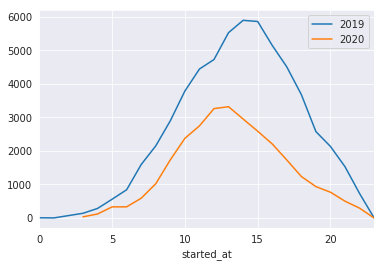

In [18]:
df_by_hour.loc[(2019,'Weekend'),'ended_at'].plot()
df_by_hour.loc[(2020,'Weekend'),'ended_at'].plot()
plt.legend(['2019','2020'])

In [19]:
temp_df = pd.read_html('https://www.yr.no/en/statistics/table/5-18700/Norway/Oslo/Oslo/Oslo%20(Blindern)?q=2020-04',flavor='html5lib')[1]

In [20]:
temp_df.head()

,DateDate,Min. temperatureMin. temp.,Max temperatureMax temp.,AverageAverage,Normal temperatureNormal temp.,Precipitation mm (measured at 07)Precip. mm (measured at 07),Snow depth cmSnow depth cm,Wind speed m/sWind speed m/s,Highest wind speed m/sHighest wind speed m/s
0,1.0,2.3°,10.9°,6.4°,2.1°,0.0,0.0,2.6,6.4
1,2.0,0.4°,9.7°,3.4°,2.2°,0.0,0.0,4.7,9.4
2,3.0,0.2°,8.2°,3.7°,2.3°,0.7,0.0,4.3,6.3
3,4.0,-2.7°,7.3°,3.1°,2.5°,0.0,0.0,3.4,5.3
4,5.0,2.9°,8.6°,4.9°,2.6°,0.3,0.0,1.9,3.7


In [21]:
import re
def remove_duplicate_word(string):
    word_with_uppercase = re.search('^[A-Z].*[A-Z]',string).group()
    return word_with_uppercase[:-1]

In [22]:
temp_df.columns = temp_df.columns.map(lambda x: remove_duplicate_word(x))

In [23]:
temp_df.head()

,Date,Min. temperature,Max temperature,Average,Normal temperature,Precipitation mm (measured at 07),Snow depth cm,Wind speed m/s,Highest wind speed m/s
0,1.0,2.3°,10.9°,6.4°,2.1°,0.0,0.0,2.6,6.4
1,2.0,0.4°,9.7°,3.4°,2.2°,0.0,0.0,4.7,9.4
2,3.0,0.2°,8.2°,3.7°,2.3°,0.7,0.0,4.3,6.3
3,4.0,-2.7°,7.3°,3.1°,2.5°,0.0,0.0,3.4,5.3
4,5.0,2.9°,8.6°,4.9°,2.6°,0.3,0.0,1.9,3.7


In [24]:
#format date in a DatetimeIndex
temp_df['Date'] = pd.DatetimeIndex(temp_df['Date'].map(lambda x: str(x) + ' April 2020'))

In [25]:
#We see that the temperatures vary a lot, this might be helpful for separating rides data
temp_df.sort_values(by='Average')

,Date,Min. temperature,Max temperature,Average,Normal temperature,Precipitation mm (measured at 07),Snow depth cm,Wind speed m/s,Highest wind speed m/s
18,2020-04-19,3.1°,17.3°,10.1°,5.0°,0.3,0.0,2.6,5.7
14,2020-04-15,3.9°,19.4°,11.4°,4.3°,0.0,0.0,4.1,7.7
19,2020-04-20,5.8°,19.3°,12.7°,5.2°,0.0,0.0,2.3,3.9
22,2020-04-23,6.1°,19.5°,13.1°,5.9°,0.0,0.0,2.1,5.7
21,2020-04-22,4.9°,21.9°,13.6°,5.6°,0.0,0.0,1.8,3.1
20,2020-04-21,7.8°,20.8°,14.2°,5.4°,0.0,0.0,2.1,3.7
3,2020-04-04,-2.7°,7.3°,3.1°,2.5°,0.0,0.0,3.4,5.3
10,2020-04-11,-1.6°,9.8°,3.3°,3.6°,0.0,0.0,2.5,4.6
1,2020-04-02,0.4°,9.7°,3.4°,2.2°,0.0,0.0,4.7,9.4
2,2020-04-03,0.2°,8.2°,3.7°,2.3°,0.7,0.0,4.3,6.3


In [26]:
#Coherently, we are going to use only the day indication for the rides
df = df.reset_index()
df['started_at'] = df['started_at'].dt.date
df['ended_at'] = df['ended_at'].dt.date

In [27]:
#are there any cases in which we cannot identify the two columns?
np.any([df['started_at']!=df['ended_at']])

True

In [28]:
#We check how many cases are there
odd_rows = df[df['started_at']!=df['ended_at']].shape[0]
fraction_odd_rows = odd_rows / df.shape[0]
fraction_odd_rows

0.0007221382087574125

Clearly, the amount of rides that start and end on different days is negligible.

In [29]:
df_same = df[df['started_at']==df['ended_at']].drop('ended_at',axis=1)
df_same.columns = pd.Index(['Date']).append(df_same.columns[1:])

In [30]:
df_same['Date'] = df_same['Date'].astype('datetime64[ns]')

In [31]:
df_total = df_same.join(temp_df.set_index('Date'),on='Date')

In [32]:
df_variations.index = df_variations.index.date
#df_variations

In [33]:
df_variations.index = df_variations.index.astype('datetime64[ns]')
df_variations

2020-04-01    946.000000
2020-04-02     -0.572964
2020-04-03     -0.633101
2020-04-04     -0.609373
2020-04-05     -0.731902
2020-04-06     -0.230754
2020-04-07     -0.433848
2020-04-08     -0.605254
2020-04-09     -0.615089
2020-04-10     -0.624717
2020-04-11     -0.850159
2020-04-12     -0.579843
2020-04-13     -0.525794
2020-04-14     -0.651416
2020-04-15     -0.310462
2020-04-16     -0.467059
2020-04-17     -0.197385
2020-04-18     -0.090652
2020-04-19     -0.264864
2020-04-20     -0.083466
2020-04-21     -0.387369
2020-04-22     -0.453594
2020-04-23     -0.547196
2020-04-24     -0.608595
2020-04-25     -0.654891
2020-04-26     -0.550844
2020-04-27     -0.862761
2020-04-28     -0.583553
2020-04-29           NaN
Name: ended_at, dtype: float64

In [34]:
df_variations.index

DatetimeIndex(['2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04',
               '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08',
               '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12',
               '2020-04-13', '2020-04-14', '2020-04-15', '2020-04-16',
               '2020-04-17', '2020-04-18', '2020-04-19', '2020-04-20',
               '2020-04-21', '2020-04-22', '2020-04-23', '2020-04-24',
               '2020-04-25', '2020-04-26', '2020-04-27', '2020-04-28',
               '2020-04-29'],
              dtype='datetime64[ns]', freq=None)

In [40]:
df_var_temp = temp_df.join(df_variations,on='Date')

In [41]:
df_var_temp.columns = df_var_temp.columns[:-1].append(pd.Index(['Variation']))

In [79]:
df_var_temp.loc[:,['Min. temperature','Max temperature','Average']] = df_var_temp.loc[:,['Min. temperature','Max temperature','Average']].applymap(lambda x: float(x.rstrip('°')))

/home/alle/.local/lib/python3.5/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/alle/.local/lib/python3.5/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


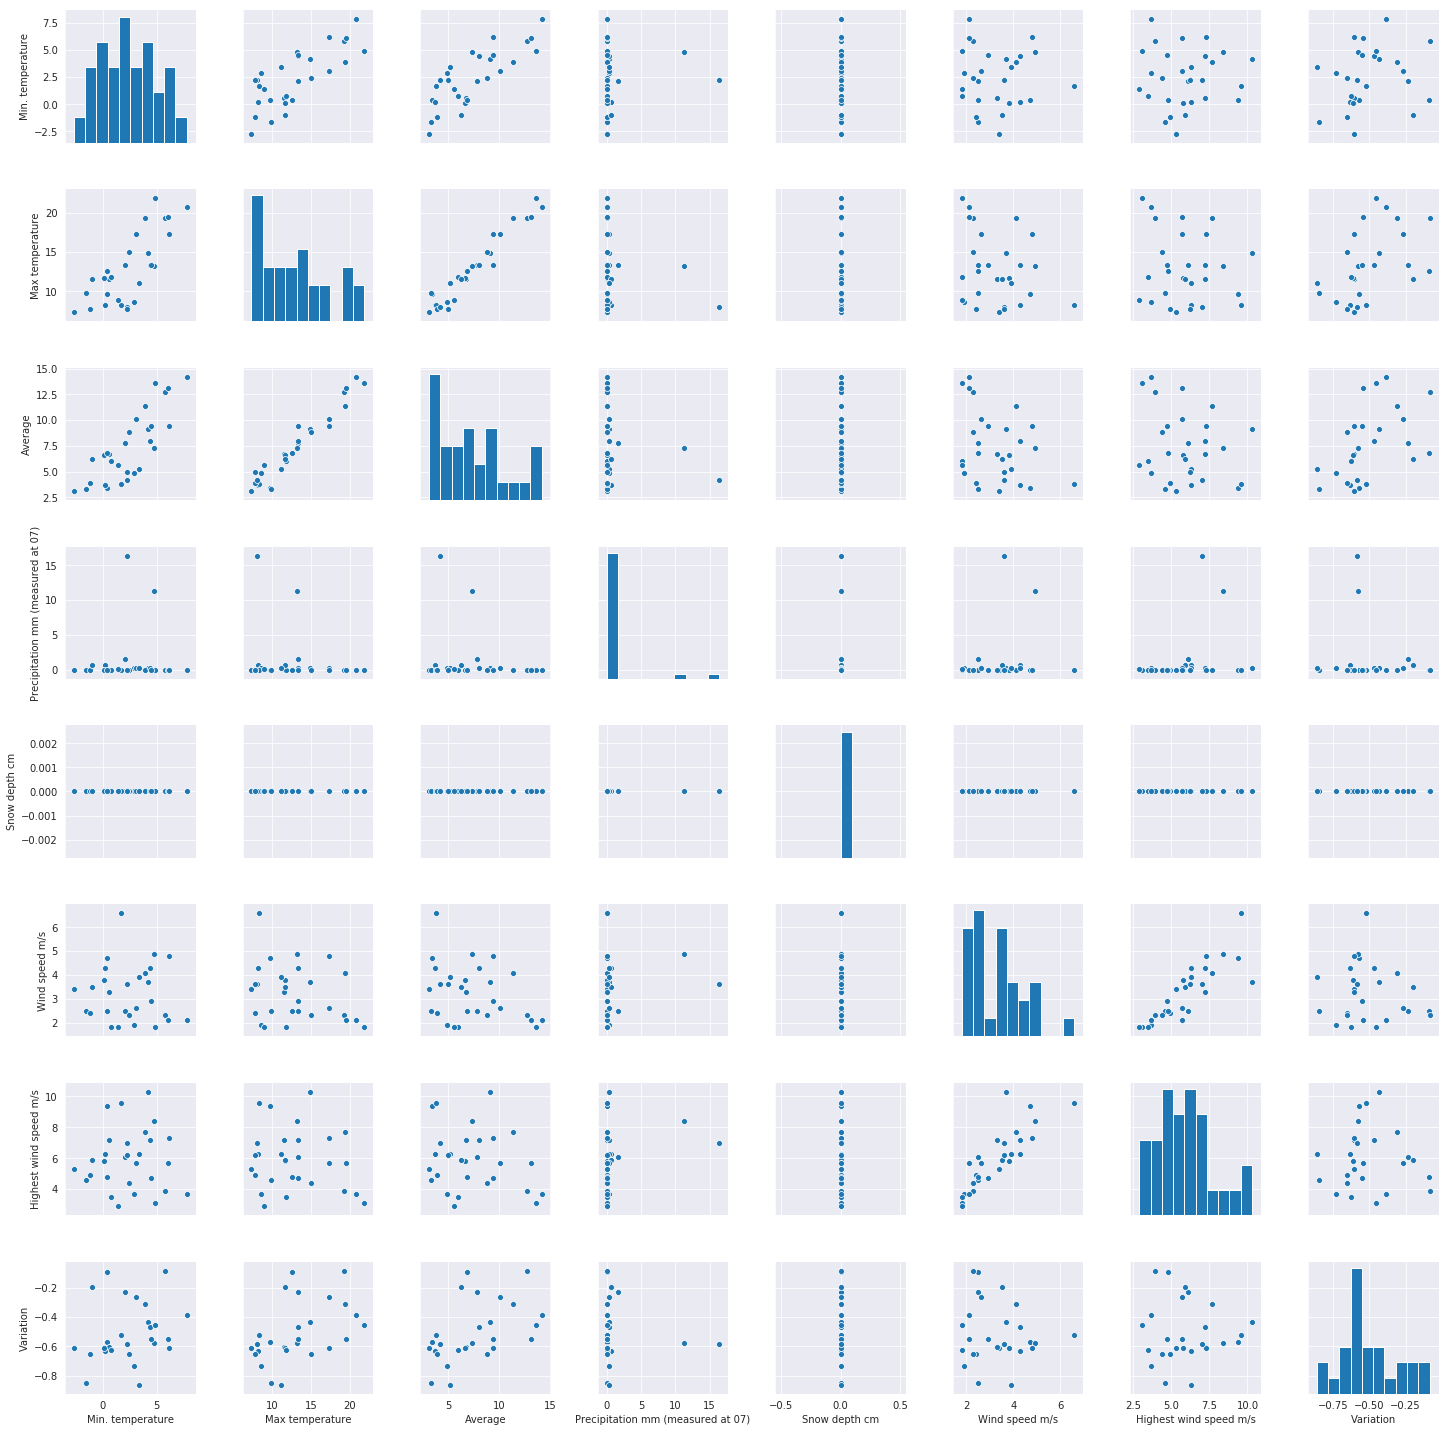

In [80]:
sns.pairplot(df_var_temp.drop(0))

In [81]:
df_var_temp.corr()

,Min. temperature,Max temperature,Average,Precipitation mm (measured at 07),Snow depth cm,Wind speed m/s,Highest wind speed m/s,Variation
Min. temperature,1.000000,0.755521,0.807640,0.079241,NaN,-0.041457,0.018924,-0.011175
Max temperature,0.755521,1.000000,0.967523,-0.174378,NaN,-0.257833,-0.152772,-0.101074
Average,0.807640,0.967523,1.000000,-0.160857,NaN,-0.332174,-0.220164,-0.062318
Precipitation mm (measured at 07),0.079241,-0.174378,-0.160857,1.000000,NaN,0.210153,0.236383,-0.061502
Snow depth cm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wind speed m/s,-0.041457,-0.257833,-0.332174,0.210153,NaN,1.000000,0.834354,-0.111114
Highest wind speed m/s,0.018924,-0.152772,-0.220164,0.236383,NaN,0.834354,1.000000,0.038047
Variation,-0.011175,-0.101074,-0.062318,-0.061502,NaN,-0.111114,0.038047,1.000000


In this plot matrix we are mainly interested in the last row, where the "Variation" datum is plotted against the others. The correlation factors can also be read in the table. The only conclusion that we can draw is that _the variation in the number of rides is not correlated with the weather_.

Note that this may be caused by the little data available: in April 2020 there were only 3 rainy days, and these are too few to actually deduce any trend. Should we had a larger share of rainy days we might have attempted to exploit some correlation, but not in the actual case.